<h1>
<center>
Dataquest Guided Project 15:
Predicting House Sale Price
</center>
</h1>

## Introduction

This is part of the Dataquest program.

- part of paths **Data Scientist in Python**
    - Step 6: **Machine Learning**
        - Course 4:**Linear Regression for Machine Learning **
            - The Linear Regression Model
            - Feature Selection
            - Gradient Descent
            - Ordinary Least Square
            - Processing and Transforming Features
            
As this is a guided project, we are following and deepening the steps suggested by Dataquest. In this project, we will practice to build a linear regression model and work on processing and transforming the features to improve the models we made.

## Use case : Predicting House Sale Prices

We will work with housing data for the city of Ames, Iowa, USA, from 2006 to 2010. The data was collected for research purpose; the resulting article can be found [here](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf). Information about the different columns in the data can be found [here](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)

We will set up a pipeline of functions that will let us quickly iterate on different models : 
![pipeline](https://s3.amazonaws.com/dq-content/240/pipeline.svg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("husl")
sns.set_style("white")

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

## Load the dataset

In [2]:
df = pd.read_csv("AmesHousing.tsv", delimiter ="\t")
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

## Functions

In [3]:
def transform_features(df, percent_missing=5):
    
    # Drop numerical columns with more than 5% missing value (can be changed in parameter)
    missing_value_count = df.isnull().sum()
    more_than_5_percent = missing_value_count[missing_value_count > len(df) * percent_missing/100]
    
    df = df.drop(more_than_5_percent.index, axis=1)
    
    # Drop text values with any missing data
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    # Replace numerical columns that has missing data with the most frequent ones
    num_missing = df.select_dtypes(include=["integer", "float"]).isnull().sum() 
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)]
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient="records")[0]
    df = df.fillna(replacement_values_dict)
    
    # Replace years by duration, drop negative values
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)
    
    # Drop columns not useful for machine learning or that leak data about the final sale
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    
    return df

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    
    # keep features with a correlation coefficient more than 0.4 (can be changed in parameter)
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    # Nominal feature we'll keep
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Keep categorical values with less than 10 unique values (can be changed in parameter)
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    #Select the remaining text column, convert it to categorical and them create dummy columns.
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])

        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)

        avg_rmse = np.mean(rmse_values)
        return avg_rmse

Let's test the function on the dataset

In [4]:
transformed = transform_features(df)
selected = select_features(transformed)
rmse = train_and_test(selected)
rmse

33367.287183402834

## Feature Engineering
### Steps to create the transform_features function

Let's removing features with many missing values, diving deeper into potential categorial features, and transforming text and numerical columns. 
We want to update transform_features() so that any column from the data frame with more than 25% (or another cutoff value) missing value is dropped. 
We'll also remove any columns that leak information about the sale. The goal is to :
- Remove Features that we don't want to use in the model, just based on the number of missing values or data leakage
- Transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc.)
- Create new features by combining other features

Which columns contain less than 5% missing values?

In [5]:
missing_value_count = df.isnull().sum()
more_than_5_percent = missing_value_count[(missing_value_count > len(df) *5/100)]
df = df.drop(more_than_5_percent.index, axis=1)

Let's drop text column with any missing data

In [6]:
text_missing_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
drop_missing_cols_2 = text_missing_counts[text_missing_counts > 0]
df = df.drop(drop_missing_cols_2.index, axis=1)

For numerical columns, let's replace the missing values with the most frequent one : 

In [7]:
num_missing = df.select_dtypes(include=["integer", "float"]).isnull().sum() 
fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)]
replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient="records")[0]
df = df.fillna(replacement_values_dict)

Let's create new columns giving the number of years since built and remodeling. We have to avoid netagive values!

In [8]:
years_sold = df['Yr Sold'] - df['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [9]:
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [10]:
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

## Drop rows with negative values for both of these new features
df = df.drop([1702, 2180, 2181], axis=0)

df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

Which columns aren't useful for Machine Learning?

In [11]:
df = df.drop(["PID", "Order"], axis=1)

Which columns leak data about the final sale?

In [12]:
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

## Feature Selection
### Steps to create the select_features function

Let's generate a correlatino heatmap matrix of the numerical features in the training dataset. 

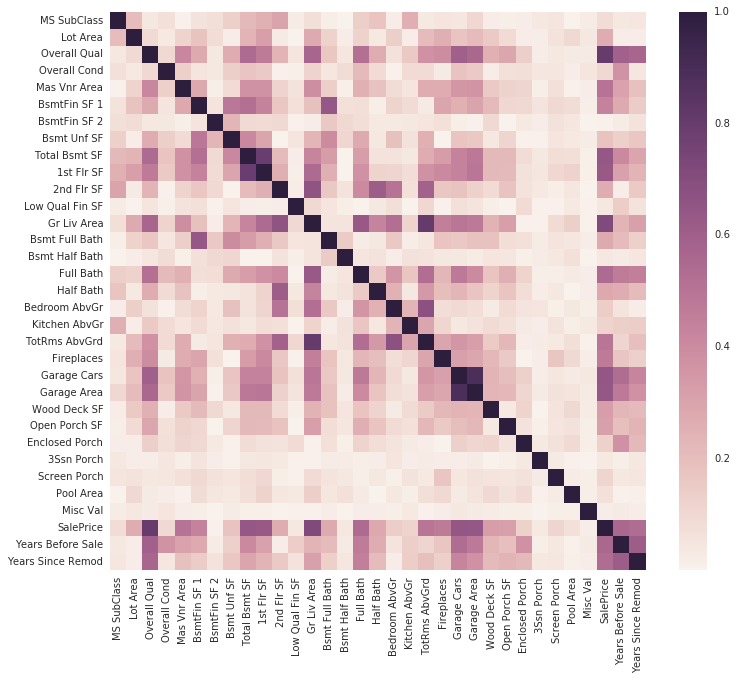

In [13]:
numerical_df = df.select_dtypes(include=['int', 'float'])
numerical_corr = numerical_df.corr().abs()
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_corr);

Let's calculate the correlation coefficients with our target column : SalePrice

In [14]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values(ascending=False)
abs_corr_coeffs

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

We'll choose to keep features with a correlation coefficient more than 0.4 .

After reading the documentation, the categorical columns that we'll keep are the following : 

In [15]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.We decided to keep 10 unique values.

In [16]:
transform_cat_cols = []
for col in nominal_features:
    if col in df.columns:
        transform_cat_cols.append(col)

uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
df = df.drop(drop_nonuniq_cols, axis=1)

Select the remaining text column, convert it to categorical and them create dummy columns.

In [17]:
text_cols = df.select_dtypes(include=['object'])
for col in text_cols:
    df[col] = df[col].astype('category')
    
df = pd.concat([
    df, 
    pd.get_dummies(df.select_dtypes(include=['category']))
], axis=1)

## Train and Test

Let's add some validation options to our train and test function. We'll add a k parameter to our function.

When k = 0, we'll perform holdout validation, with the first 1460 rows as train data, and the remaining for testing. 

When k = 1, we'll perform simple cross validation.

When k is greater than 1, we'll implement k-fold cross validation using k folds. 

In the following example, we'll study the differences in RMSE as k varies. It would be interesting to change the feature functions parameters. 

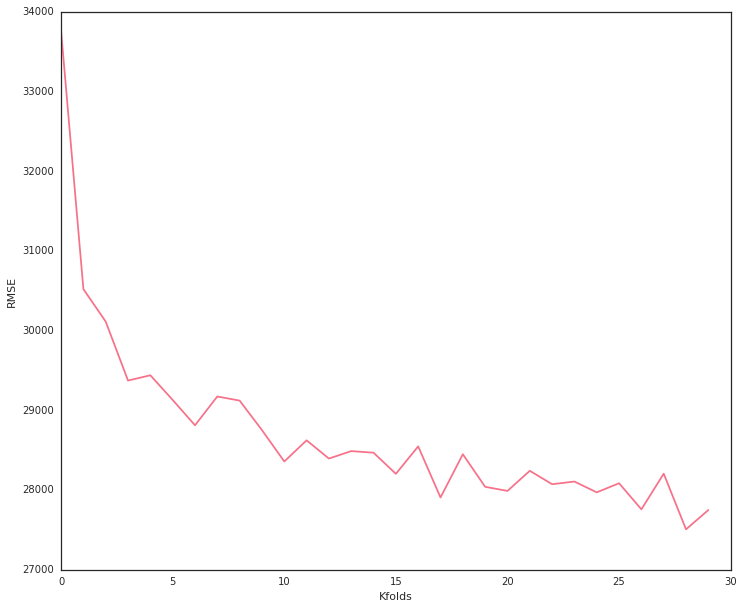

In [18]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')

transformed_data = transform_features(data, percent_missing=0.05)
final_data = select_features(transformed_data, 0.4, 10)

results = []
for i in range(30):
    result = train_and_test(final_data, k=i)
    results.append(result)
    
x = [i for i in range(30)]
y = results 

plt.figure(figsize=(12, 10))
plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('RMSE')